In [ ]:
import os
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics import StructuralSimilarityIndexMeasure

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define your data paths
images_path = '/content/drive/My Drive/Comp Neuro Project/salicon_256/stimuli/train'
saliency_path = '/content/drive/My Drive/Comp Neuro Project/salicon_256/saliency/train'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Dataset Class
class SaliencyDataset(Dataset):
    def __init__(self, stimuli_dir, saliency_dir, transform=None):
        """
        Args:
            stimuli_dir (str): Directory containing input images.
            saliency_dir (str): Directory containing ground truth saliency maps.
            transform (callable, optional): Transformation to be applied to images and saliency maps.
        """
        self.stimuli_dir = stimuli_dir
        self.saliency_dir = saliency_dir
        self.transform = transform

        # Ensure stimuli and saliency maps are aligned
        self.stimuli_files = sorted(os.listdir(stimuli_dir))[:10000]
        self.saliency_files = sorted(os.listdir(saliency_dir))[:10000]
        assert len(self.stimuli_files) == len(self.saliency_files), \
            "Number of stimuli and saliency maps must be the same."

    def __len__(self):
        return len(self.stimuli_files)

    def __getitem__(self, idx):
        # Load stimulus image
        stimulus_path = os.path.join(self.stimuli_dir, self.stimuli_files[idx])
        stimulus = Image.open(stimulus_path).convert('RGB')

        # Load saliency map (assumed grayscale)
        saliency_path = os.path.join(self.saliency_dir, self.saliency_files[idx])
        saliency = Image.open(saliency_path).convert('L')

        # Apply transformations
        if self.transform:
            stimulus = self.transform['stimulus'](stimulus)
            saliency = self.transform['saliency'](saliency)

        # Normalize saliency to [0, 1] and add a channel dimension
        # saliency = torch.tensor(np.array(saliency, dtype=np.float32) / 255.0).unsqueeze(0)
        # Removing unsqueeze here and making sure the image is of correct shape
        #saliency = torch.tensor(np.array(saliency, dtype=np.float32) / 255.0) # shape [224,224]
        #saliency = saliency # shape [1, 224,224] to match model output


        return stimulus, saliency

# Define Transforms
transform = {
    'stimulus': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'saliency': transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to match stimulus size
        transforms.ToTensor()
    ])
}

# DataLoader
dataset = SaliencyDataset(stimuli_dir=images_path, saliency_dir=saliency_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=2)

# Define the Model
class SaliencyPredictionModel(nn.Module):
    def __init__(self):
        super(SaliencyPredictionModel, self).__init__()

        # Encoder: Pretrained VGG16
        self.encoder = models.vgg16(pretrained=True).features

        # Decoder: Deconvolution layers
        self.decoder = nn.Sequential(
              nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2),
              nn.ReLU(),
              nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2),
              nn.ReLU(),
              nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2),
              nn.ReLU(),
              nn.ConvTranspose2d(64, 1, kernel_size=3, stride=2),
              nn.Sigmoid()
)

        # Resize output to match input saliency dimensions (try making convtranspose back to upsample)
        self.final_resize = nn.Upsample(size=(224, 224), mode='bilinear', align_corners=False)


    def forward(self, x):
        x = self.encoder(x)  # Extract features using encoder
        x1 = self.decoder(x)  # Generate saliency map using decoder
        x = self.final_resize(x1)  # Resize to match input size
        return x, x1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

def normalized_cross_correlation_loss(outputs, targets):
    # Flatten the tensors
    outputs = outputs.view(-1)
    targets = targets.view(-1)

    # Compute mean
    outputs_mean = torch.mean(outputs)
    targets_mean = torch.mean(targets)

    # Compute numerator and denominator
    numerator = torch.sum((outputs - outputs_mean) * (targets - targets_mean))
    denominator = torch.sqrt(torch.sum((outputs - outputs_mean)**2) *
                              torch.sum((targets - targets_mean)**2))

    # Return loss (1 - NCC to minimize)
    return 1 - (numerator / (denominator + 1e-8))

# Initialize Model, Loss Function, and Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SaliencyPredictionModel().to(device)
criterion = normalized_cross_correlation_loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Initialize lists to store losses
training_losses = []

# Training Loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for stimuli, saliencies in dataloader:
        stimuli, saliencies = stimuli.to(device), saliencies.to(device)

        # Forward pass
        outputs, x1 = model(stimuli)

        # Ensure outputs match saliencies shape
        outputs = outputs.squeeze(1)
        saliencies = saliencies.squeeze(1)

        loss = criterion(outputs, saliencies)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}")

    # Calculate average training loss for the epoch
    avg_training_loss = running_loss / len(dataloader)
    training_losses.append(avg_training_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_training_loss:.4f}")

print("Training complete.")

torch.save(model.state_dict(), '/content/drive/My Drive/Comp Neuro Project/saliency256_model.pth')

Epoch [1/20], Loss: 0.3044
Epoch [1/20], Training Loss: 0.3044
Epoch [2/20], Loss: 0.2320
Epoch [2/20], Training Loss: 0.2320
Epoch [3/20], Loss: 0.2096
Epoch [3/20], Training Loss: 0.2096
Epoch [4/20], Loss: 0.1931
Epoch [4/20], Training Loss: 0.1931
Epoch [5/20], Loss: 0.1808
Epoch [5/20], Training Loss: 0.1808
Epoch [6/20], Loss: 0.1688
Epoch [6/20], Training Loss: 0.1688
Epoch [7/20], Loss: 0.1563
Epoch [7/20], Training Loss: 0.1563
Epoch [8/20], Loss: 0.1445
Epoch [8/20], Training Loss: 0.1445
Epoch [9/20], Loss: 0.1337
Epoch [9/20], Training Loss: 0.1337
Epoch [10/20], Loss: 0.1213
Epoch [10/20], Training Loss: 0.1213
Epoch [11/20], Loss: 0.1111
Epoch [11/20], Training Loss: 0.1111
Epoch [12/20], Loss: 0.1026
Epoch [12/20], Training Loss: 0.1026
Epoch [13/20], Loss: 0.0944
Epoch [13/20], Training Loss: 0.0944
Epoch [14/20], Loss: 0.0876
Epoch [14/20], Training Loss: 0.0876
Epoch [15/20], Loss: 0.0825
Epoch [15/20], Training Loss: 0.0825
Epoch [16/20], Loss: 0.0770
Epoch [16/20], 

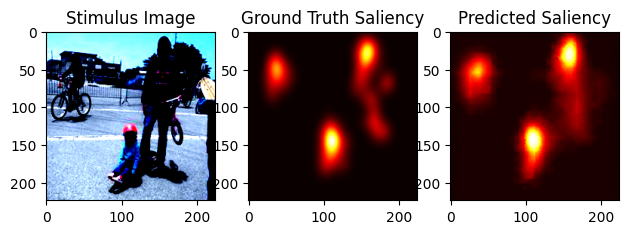

In [ ]:
# Visualize Predictions
model.eval()
with torch.no_grad():
    for stimuli, saliencies in dataloader:
        stimuli = stimuli.to(device)
        saliencies = saliencies.to(device)
        outputs, x1 = model(stimuli)

        # Visualize the first sample in the batch
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 4, 1)
        plt.imshow(stimuli[1].cpu().permute(1, 2, 0).numpy())
        plt.title('Stimulus Image')

        plt.subplot(1, 4, 2)
        plt.imshow(saliencies[1].cpu().squeeze().numpy(), cmap='hot')
        plt.title('Ground Truth Saliency')

        plt.subplot(1, 4, 3)
        plt.imshow(outputs[1].cpu().squeeze().numpy(), cmap='hot')  # Access the first batch, first channel
        plt.title('Predicted Saliency')

        plt.show()
        break

In [ ]:
val_images_path = '/content/drive/My Drive/Comp Neuro Project/salicon_256/stimuli/val'
val_saliency_path = '/content/drive/My Drive/Comp Neuro Project/salicon_256/saliency/val'

# Validation Dataset
val_dataset = SaliencyDataset(stimuli_dir=val_images_path, saliency_dir=val_saliency_path, transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)

# Load the Trained Model
model = SaliencyPredictionModel().to(device)
model.load_state_dict(torch.load('/content/drive/My Drive/Comp Neuro Project/saliency256_model.pth'))
model.eval()

# Loss function for validation
criterion = normalized_cross_correlation_loss

# Validation Loop
total_loss = 0.0
validation_losses = []

with torch.no_grad():
    for stimuli, saliencies in val_dataloader:
        stimuli, saliencies = stimuli.to(device), saliencies.to(device)

        # Forward pass
        outputs, _ = model(stimuli)

        # Ensure outputs match saliencies shape
        outputs = outputs.squeeze(1)
        saliencies = saliencies.squeeze(1)

        loss = criterion(outputs, saliencies)
        total_loss += loss.item()

        print(f"Validation Loss for current batch: {loss.item():.4f}")

        validation_losses.append(loss.item())

avg_loss = total_loss / len(val_dataloader)
print(f"Average Validation Loss: {avg_loss:.4f}")


<ipython-input-21-664351fa7791>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/My Drive/Comp Neuro Project/saliency256_mo

Validation Loss for current batch: 0.1620
Validation Loss for current batch: 0.1788
Validation Loss for current batch: 0.1444
Validation Loss for current batch: 0.1887
Validation Loss for current batch: 0.2351
Validation Loss for current batch: 0.1880
Validation Loss for current batch: 0.1745
Validation Loss for current batch: 0.1890
Validation Loss for current batch: 0.2069
Validation Loss for current batch: 0.1757
Validation Loss for current batch: 0.1823
Validation Loss for current batch: 0.2061
Validation Loss for current batch: 0.2421
Validation Loss for current batch: 0.1798
Validation Loss for current batch: 0.1747
Validation Loss for current batch: 0.2074
Validation Loss for current batch: 0.2126
Validation Loss for current batch: 0.1579
Validation Loss for current batch: 0.1785
Validation Loss for current batch: 0.1884
Validation Loss for current batch: 0.1531
Validation Loss for current batch: 0.2421
Validation Loss for current batch: 0.1956
Validation Loss for current batch:

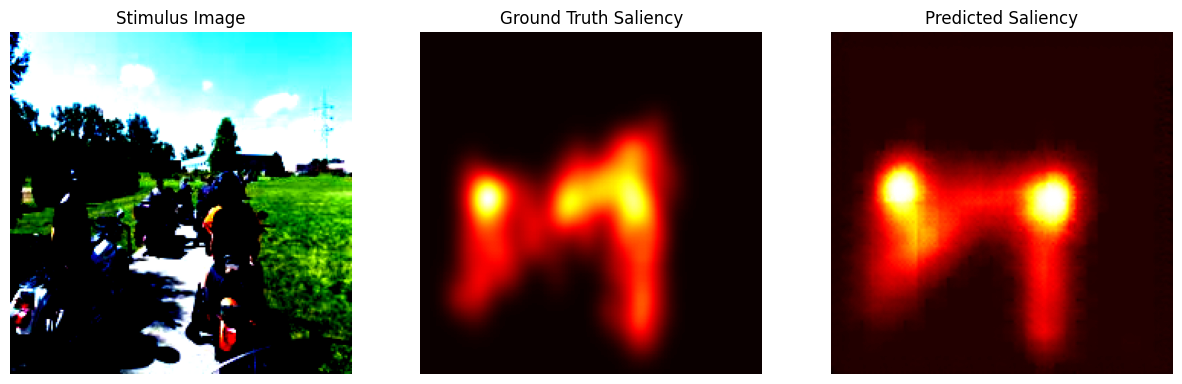

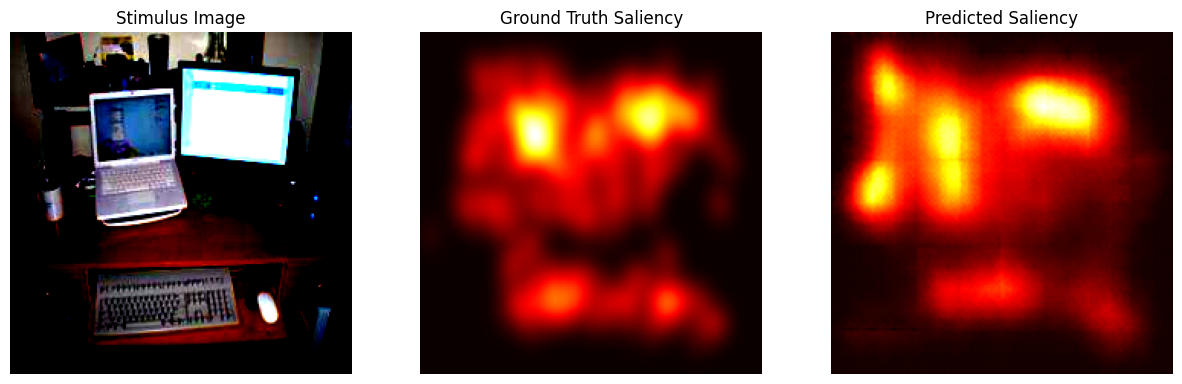

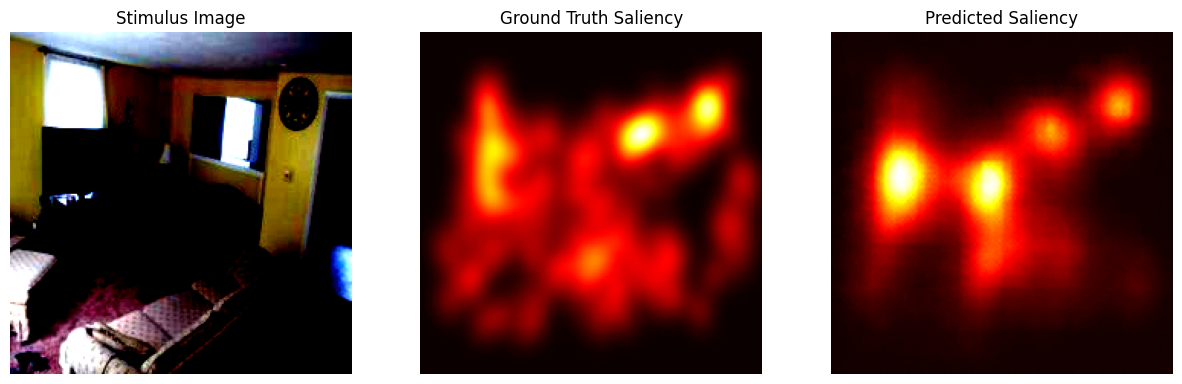

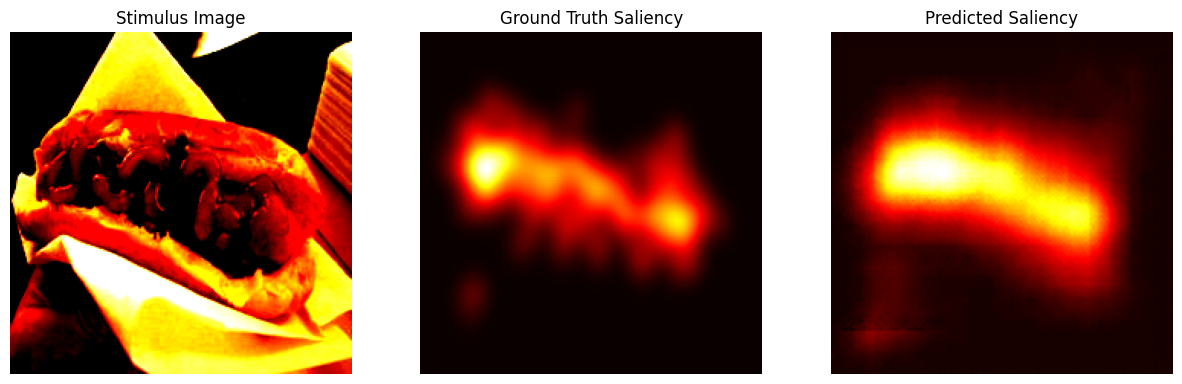

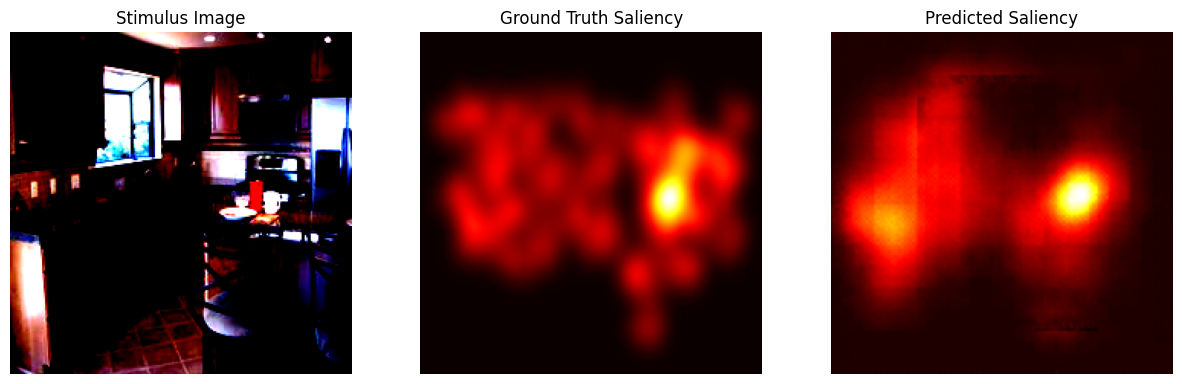

In [ ]:
# Function for Visualizing Predictions
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(stimuli, saliencies, outputs):
    for i in range(min(5, len(stimuli))):
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(stimuli[i].cpu().permute(1, 2, 0).numpy())
        plt.title('Stimulus Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(saliencies[i].squeeze(0).cpu().numpy(), cmap='hot')
        plt.title('Ground Truth Saliency')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(outputs[i].squeeze(0).cpu().numpy(), cmap='hot')
        plt.title('Predicted Saliency')
        plt.axis('off')

        plt.show()

visualize_predictions(stimuli.cpu(), saliencies.cpu(), outputs.cpu())


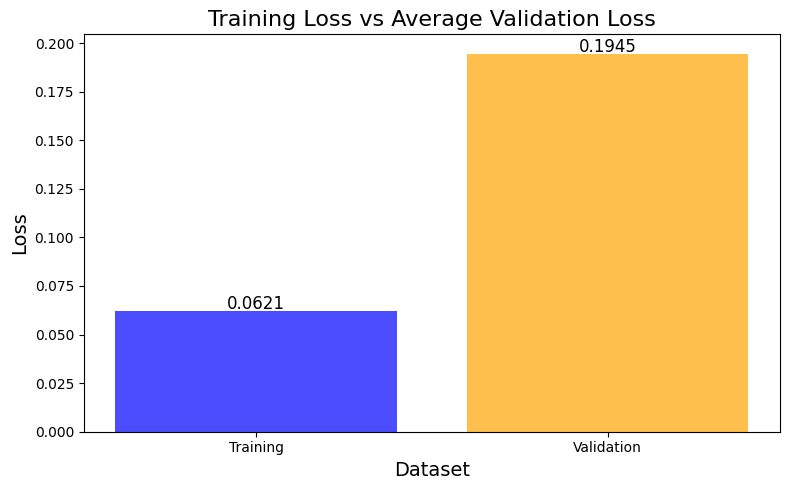

In [ ]:
import matplotlib.pyplot as plt

final_loss = running_loss/len(dataloader)
avg_validation_loss = avg_loss

datasets = ["Training", "Validation"]
avg_losses = [final_loss, avg_validation_loss]

plt.figure(figsize=(8, 5))
plt.bar(datasets, avg_losses, color=["blue","orange"], alpha=0.7)

plt.title("Training Loss vs Average Validation Loss", fontsize=16)
plt.ylabel("Loss", fontsize=14)
plt.xlabel("Dataset", fontsize=14)
plt.ylim(0, max(avg_losses) + 0.01)

for i, loss in enumerate(avg_losses):
    plt.text(i, loss + 0.001, f"{loss:.4f}", ha="center", fontsize=12)

plt.tight_layout()
plt.show()


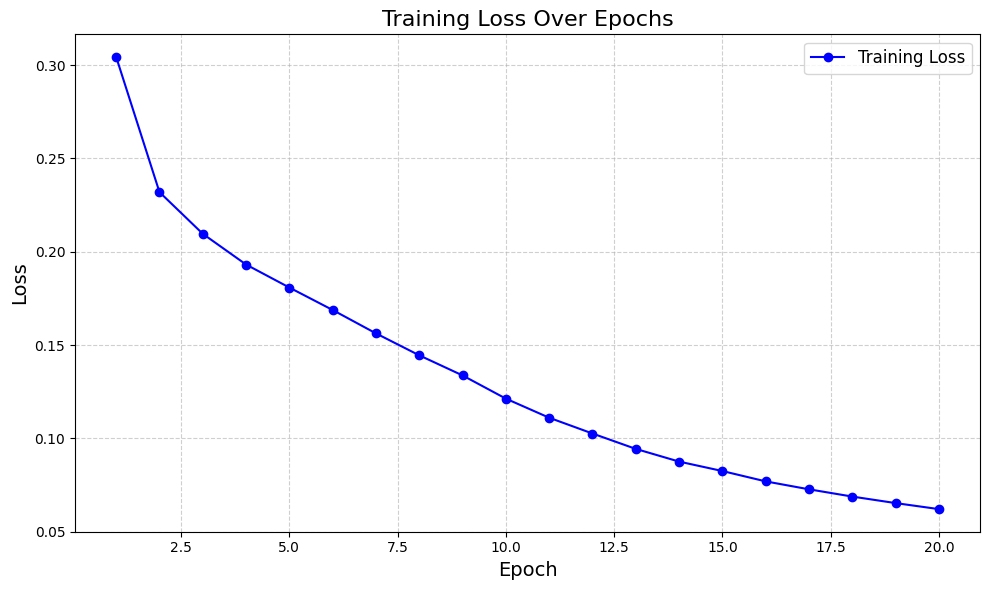

In [ ]:
import matplotlib.pyplot as plt

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), training_losses, label="Training Loss", color="blue", marker="o")

plt.title("Training Loss Over Epochs", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=12)

plt.grid(visible=True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

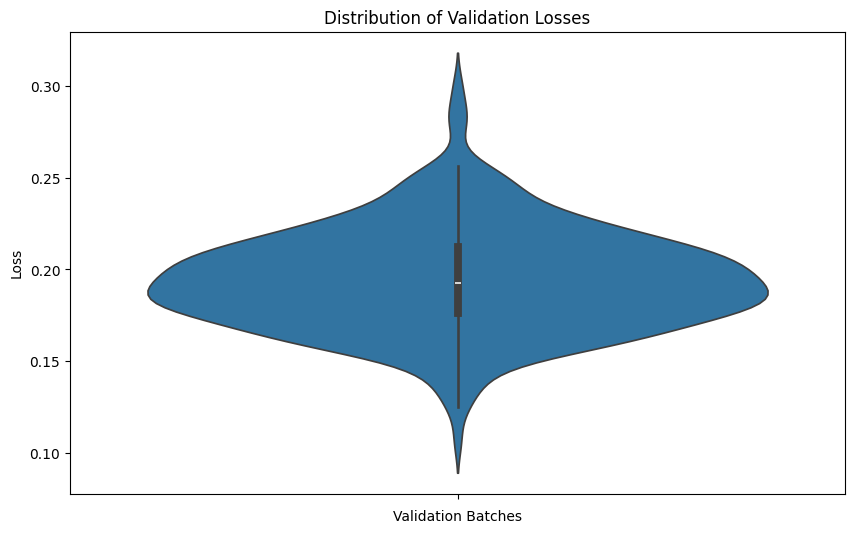

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.violinplot(data=validation_losses)
plt.title('Distribution of Validation Losses')
plt.xlabel('Validation Batches')
plt.ylabel('Loss')
plt.show()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-26-39df752d62b0>:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). I

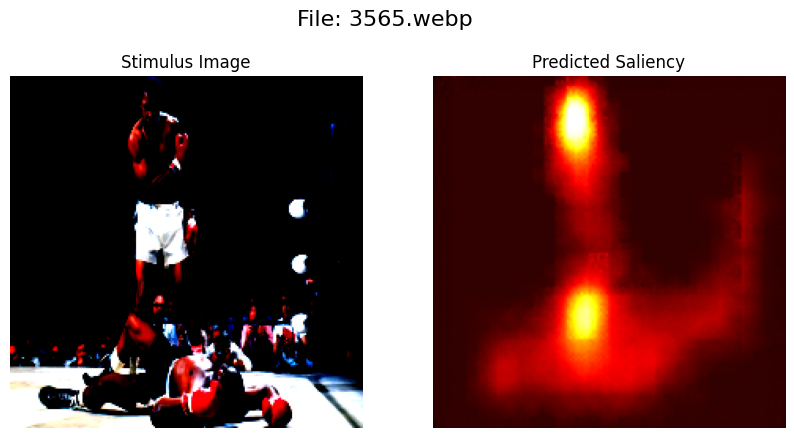

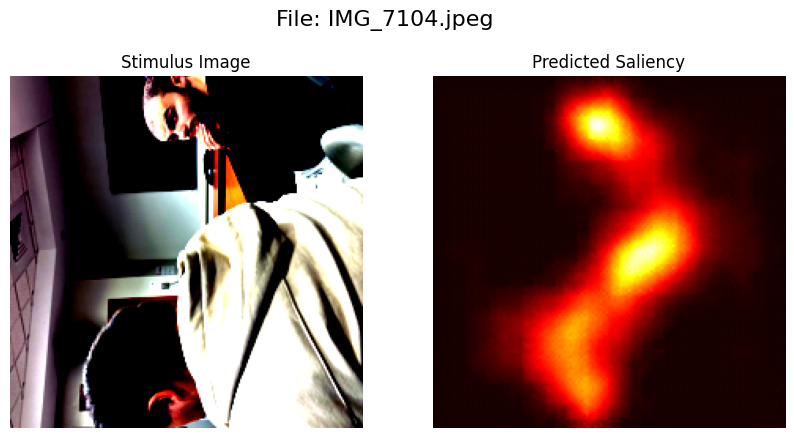

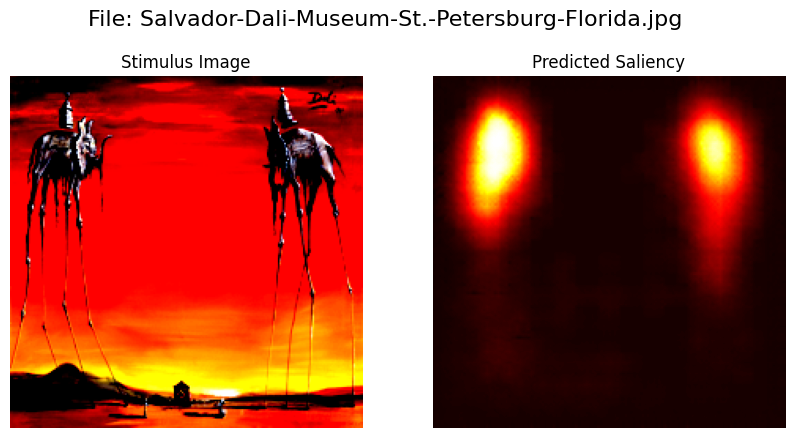

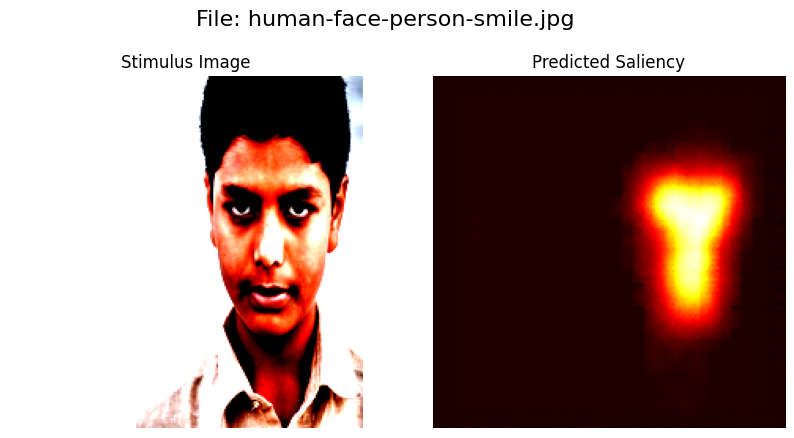

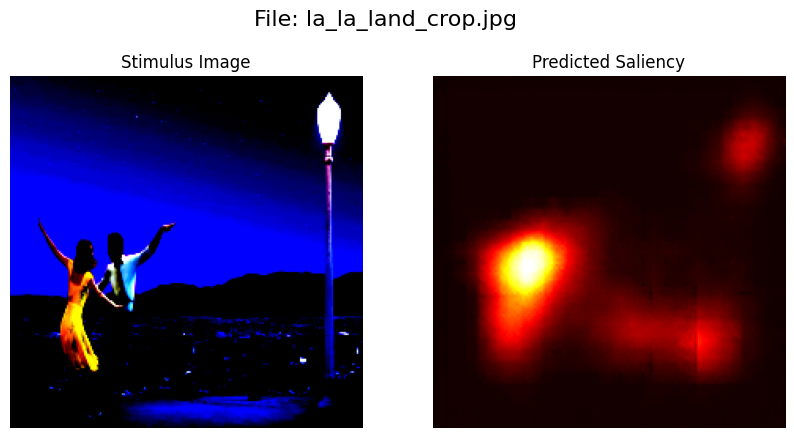

Test predictions complete.


In [ ]:
# Define Test Dataset Class
class TestImageDataset(Dataset):
    def __init__(self, stimuli_dir, transform=None):
        """
        Args:
            stimuli_dir (str): Directory containing test input images.
            transform (callable, optional): Transformation to be applied to the images.
        """
        self.stimuli_dir = stimuli_dir
        self.transform = transform
        self.stimuli_files = sorted(os.listdir(stimuli_dir))

    def __len__(self):
        return len(self.stimuli_files)

    def __getitem__(self, idx):
        stimulus_path = os.path.join(self.stimuli_dir, self.stimuli_files[idx])
        stimulus = Image.open(stimulus_path).convert('RGB')

        # Apply transformations
        if self.transform:
            stimulus = self.transform(stimulus)

        return stimulus, self.stimuli_files[idx]  # Return image and file name for reference

# Define Transforms (Same as Training)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_images_path = '/content/drive/My Drive/Comp Neuro Project/TestImages'
test_dataset = TestImageDataset(stimuli_dir=test_images_path, transform=test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)

model = SaliencyPredictionModel().to(device)
model.load_state_dict(torch.load('/content/drive/My Drive/Comp Neuro Project/saliency256_model.pth'))
model.eval()

# Prediction and Visualization
def visualize_test_predictions(image, prediction, filename):
    """Visualize the original image and predicted saliency map."""
    plt.figure(figsize=(10, 5))

    # Input stimulus image
    plt.subplot(1, 2, 1)
    plt.imshow(image.cpu().permute(1, 2, 0).numpy())
    plt.title('Stimulus Image')
    plt.axis('off')

    # Predicted saliency map
    plt.subplot(1, 2, 2)
    plt.imshow(prediction.squeeze(0).cpu().numpy(), cmap='hot')
    plt.title('Predicted Saliency')
    plt.axis('off')

    plt.suptitle(f"File: {filename}", fontsize=16)
    plt.show()

# Generate Predictions
with torch.no_grad():
    for stimuli, filenames in test_dataloader:
        stimuli = stimuli.to(device)

        # Forward pass
        predictions, _ = model(stimuli)

        # Visualize predictions
        for i in range(len(stimuli)):
            visualize_test_predictions(stimuli[i].cpu(), predictions[i].cpu(), filenames[i])

print("Test predictions complete.")
